# Overview

The goal of this notebook is to design a machine learning model to predict the salary of a job as best as possible from the information in the job description and to inerpret it afterwards. The procedure was as follows:
- [Test of a baseline](#baseline)
- [Test of linear models](#linear_models)
- [Test of non-linear models](#non-linear_models)
- [Interpretation of the results](#interpretation)
- [Summary of the results](#summary)

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.svm import SVR
from tqdm import tqdm
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/data_wide.csv")
df = df.loc[df["title_category"] != "Others"]
df.dropna(subset=["average_salary"], inplace=True)
print(df.shape)
df.head()

(1687, 103)


,link,company,title,content,rating,num_ratings,company_link,release_date,company_size,permanent_employment,...,creativity,leadership,flexibility,business_focus,initiative,structured_working,little_experience,much_experience,no_experience_information,some_experience
1,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,...,False,False,False,False,False,False,False,False,True,False
2,https://www.stepstone.de/stellenangebote--Mana...,BIG direkt gesund,Manager (m/w/d) Data Science & Statistik,Direkter geht Karriere nicht.Einstieg bei der ...,4.3,16 Bewertungen,NaN,2022-06-03,NaN,True,...,False,False,False,False,False,False,False,False,True,False
3,https://www.stepstone.de/stellenangebote--Data...,METRO Markets GmbH,Data Science Lead,We create the future of B2B commerce by giving...,NaN,NaN,NaN,2022-06-01,NaN,True,...,False,False,True,False,False,False,False,True,False,False
4,https://www.stepstone.de/stellenangebote--Busi...,R+V Allgemeine Versicherung AG,Business Analyst / Data Science (m/w/d),Wie sich die Versicherung von morgen anfühlen ...,4.4,247 Bewertungen,https://www.stepstone.de/cmp/de/R-V-Allgemeine...,2022-06-01,"10,001+",True,...,False,False,False,False,True,False,False,False,True,False
8,https://www.stepstone.de/stellenangebote--Data...,CHECK24,Data Science & Artificial Intelligence Manager...,CHECK24 ist eines der führenden Online-Unterne...,4.5,179 Bewertungen,https://www.stepstone.de/cmp/de/CHECK24-112642...,2022-05-28,2501-5000,True,...,False,True,False,False,False,False,False,False,True,False


Within the EDA, attributes have already been identified that are not relevant with regard to the salary of a job. These are excluded from the outset during model building. Subsequently, a test data set is split off from the remaining data, which will later be used to obtain an unbiased estimate of the model quality.

In [3]:
df = df[["company", "company_size", "home_office_possible", "part_time", "title_category", "experience_level", "average_salary", "main_location", 
         "main_region", "multiple_locations", "main_industry", "master", "phd", "bachelor", "little_experience", "much_experience", "some_experience"]]
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_train.shape, df_test.shape

((1349, 17), (338, 17))

There are three attributes with missing values. Since all attributes are categorical features, it is easy to add an additional category "missing_value" later.

In [4]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

company_size          345
main_industry         217
main_region            42
multiple_locations      0
much_experience         0
little_experience       0
bachelor                0
phd                     0
master                  0
company                 0
dtype: int64

The target variable is approximately normally distributed, but contains a relatively extreme outlier. Especially when using a linear model, it can therefore still be useful to transform the target to minimize the effect of the extremely large values and to better approximate the remaining data points.

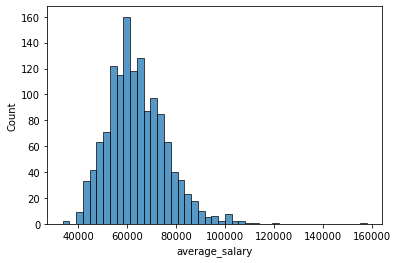

In [5]:
sns.histplot(x=df_train["average_salary"]);

<a id="baseline"></a>

## Baseline

To get a feel for the difficulty of the problem, the first step is to establish a simple baseline performance. In a regression problem, the use of the target mean for all predictions is usually suitable for this purpose. In the following, the Mean Absolute Error (MAE) is always used to evaluate the model, since large errors should not be weighted more heavily than small ones.

In [6]:
X = df_train.drop("average_salary", axis=1)
y = df_train["average_salary"]
model = DummyRegressor(strategy="mean")
results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 9328.610852440717
test score: 9331.5807791647


<a id="linear_models"></a>

## Linear Models

As a first model, a linear regression without further modifications is tested on the problem. During preprocessing, all missing values are first replaced by the missing_value category. Then, all categorical features are converted to numeric features using one-hot encoding. Scaling of the data is not necessary because the dataset contains only categorical features.

In [7]:
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", LinearRegression())
])

results = cross_validate(pipe, X, y, scoring="neg_mean_absolute_error", return_train_score=True)
print(f"train score: {np.abs(np.mean(results['train_score']))}")
print(f"test score: {np.abs(np.mean(results['test_score']))}")

train score: 3119.9537800193493
test score: 7090.860073052829


The linear regression already provides a clear improvement over the baseline. However, the large difference between training and test error suggests that the model overfits the training data. Therefore, the effect of additional regularization will be investigated next. Three different models are tested for this purpose:
- Lasso Regression (L1 regularization)
- Ridge Regression (L2 regularization)
- Elastic Net (combination of L1 and L2 regularization)

Simultaneously, the effect of different variants in the coding of categorical variables is investigated. In one-hot encoding, the hyperparameter "min_frequency" is investigated, which influences when rare categories should be combined into one. Furthermore, target encoding is tested as an alternative. The hyperparameter "smoothing" is also used to avoid overfitting rare categories. An ordinal encoding is omitted at this point, since none of the features is assumed to have an ordinal relationship. 

In [8]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", Lasso())
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__alpha": list(range(1, 30))},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__alpha": list(range(1, 30))}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5081.107324479164
test score: 6369.832715922211


{'model__alpha': 9,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

In [9]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", Ridge())
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__alpha": list(range(1, 30))},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__alpha": list(range(1, 30))}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5136.117273618794
test score: 6361.139174789741


{'model__alpha': 4,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

In [10]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", ElasticNet())
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__alpha": np.arange(0.001, 0.1, 0.001),
               "model__l1_ratio": np.arange(0.1, 1, 0.1)},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__alpha": np.arange(0.001, 0.1, 0.001),
               "model__l1_ratio": np.arange(0.1, 1, 0.1)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5049.485576493969
test score: 6362.752335765758


{'model__l1_ratio': 0.8,
 'model__alpha': 0.016,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

All three variants of regularization deliver very similar results and show a significant improvement over the variant without regularization. In all three cases, pre-processing using One Hot Encoder without a summary of rare categories yielded the best results. Since neither the L1 regularization nor a summary of rare categories brought an improvement, it becomes clear that also in the rare categories obviously much information content is and the model for a best possible performance cannot do without these.

Next, we check whether a log transformation of the target can lead to a further improvement.

In [11]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__regressor__alpha": [1e-5, 1e-4, 1e-3]},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__regressor__alpha": [1e-5, 1e-4, 1e-3]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 4653.232568532231
test score: 6261.439911716512


{'model__regressor__alpha': 0.0001,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

In [12]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__regressor__alpha": list(range(1, 30))},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__regressor__alpha": list(range(1, 30))}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 4879.94629980855
test score: 6232.501559764298


{'model__regressor__alpha': 3,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

In [13]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(ElasticNet(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__regressor__alpha": [1e-5, 1e-4, 1e-3],
               "model__regressor__l1_ratio": np.arange(0.1, 1, 0.1)},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__regressor__alpha": [1e-5, 1e-4, 1e-3],
               "model__regressor__l1_ratio": np.arange(0.1, 1, 0.1)}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 5104.673786607447
test score: 6256.352444374201


{'model__regressor__l1_ratio': 0.1,
 'model__regressor__alpha': 0.001,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

The transformation of the target reduces the error significantly in all three cases. The ridge regression delivers slightly better results than the other two variants and will therefore be further improved in the following step. Finally, we will investigate whether the inclusion of interactions between features can improve the predictions. 

In [14]:
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("features", PolynomialFeatures(include_bias=False)),
    ("model", TransformedTargetRegressor(Ridge(), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__regressor__alpha": list(range(30, 100))},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__regressor__alpha": list(range(30, 100))}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 4132.892259535844
test score: 6266.144746182386


{'model__regressor__alpha': 51,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

Including nonlinear relationships in the regression did not improve it. Since there are now significantly more features available, the model is more susceptible to overfitting. This is evident from the larger difference between training and testing error. 

<a id="non-linear_models"></a>

## Non-linear Models

Nachdem mit der Ridge Regression ein effizientes und leicht zu interpretierendes Modell gefunden wurde, soll an dieser Stelle überprüft werden, ob dessen Performanz durch eine Auswahl komplexerer Modelle noch übertroffen werden kann. Dafür werden im Folgenden drei unterschiedliche Modelle überprüft:
- Support Vector Regression
- Random Forest
- Gradient Boosting (XGBoost)

In [15]:
# Support Vector Regression
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", SVR(max_iter=10000))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__C": [1000, 2500, 5000, 7500, 10000, 20000],
               "model__kernel": ["linear", "rbf", "poly"],
               "model__epsilon": [0.001, 0.01, 0.1, 1, 10]},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__C": [1000, 2500, 5000, 7500, 10000, 20000],
               "model__kernel": ["linear", "rbf", "poly"],
               "model__epsilon": [0.001, 0.01, 0.1, 1, 10]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 4473.650892183423
test score: 6237.354529326022


{'model__kernel': 'linear',
 'model__epsilon': 0.1,
 'model__C': 2500,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

In [16]:
# Support Vector Regression with log transformed target
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(SVR(max_iter=10000), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__regressor__C": [1000, 2500, 5000, 10000, 20000],
               "model__regressor__kernel": ["linear", "rbf", "poly"],
               "model__regressor__epsilon": [0.001, 0.01, 0.1, 1, 10]},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__regressor__C": [1000, 2500, 5000, 10000, 20000],
               "model__regressor__kernel": ["linear", "rbf", "poly"],
               "model__regressor__epsilon": [0.001, 0.01, 0.1, 1, 10]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 4531.509606666095
test score: 6755.346330072041


{'model__regressor__kernel': 'rbf',
 'model__regressor__epsilon': 0.1,
 'model__regressor__C': 5000,
 'encoder__ohe__min_frequency': None,
 'encoder': Pipeline(steps=[('imputer',
                  SimpleImputer(fill_value='missing_value',
                                strategy='constant')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))])}

In [17]:
# Random Forest
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", RandomForestRegressor(random_state=0))
])

param_grid = [{"encoder": [onehot_encoding],               
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__criterion": ["squared_error", "absolute_error"],
               "model__n_estimators": [100, 200, 500, 1000, 2000], 
               "model__max_depth": [5, 10, 15, 20, 30, None],
               "model__max_features": [0.3, 0.5, 0.7, 0.9, 1],
               "model__max_samples": [0.3, 0.5, 0.7, 0.9, 1],
               "model__min_samples_leaf": [1, 3, 5],
               "model__ccp_alpha": [0, 0.5, 1, 5, 10, 20, 50]},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__criterion": ["squared_error", "absolute_error"],
               "model__n_estimators": [100, 200, 500, 1000, 2000], 
               "model__max_depth": [5, 10, 15, 20, 30, None],
               "model__max_features": [0.3, 0.5, 0.7, 0.9, 1],
               "model__max_samples": [0.3, 0.5, 0.7, 0.9, 1],
               "model__min_samples_leaf": [1, 3, 5],
               "model__ccp_alpha": [0, 0.5, 1, 5, 10, 20, 50]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 4624.1258015856165
test score: 6470.90633349167


{'model__n_estimators': 2000,
 'model__min_samples_leaf': 3,
 'model__max_samples': 0.9,
 'model__max_features': 0.5,
 'model__max_depth': None,
 'model__criterion': 'absolute_error',
 'model__ccp_alpha': 10,
 'encoder__smoothing': 10.0,
 'encoder': TargetEncoder(smoothing=10.0)}

In [18]:
# Random Forest with log transformed target
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(RandomForestRegressor(random_state=0)))
])

param_grid = [{"encoder": [onehot_encoding],               
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__regressor__criterion": ["squared_error", "absolute_error"],
               "model__regressor__n_estimators": [100, 200, 500, 1000, 2000], 
               "model__regressor__max_depth": [5, 10, 15, 20, 30, None],
               "model__regressor__max_features": [0.3, 0.5, 0.7, 0.9, 1],
               "model__regressor__max_samples": [0.3, 0.5, 0.7, 0.9, 1],
               "model__regressor__min_samples_leaf": [1, 3, 5],
               "model__regressor__ccp_alpha": [0, 0.5, 1, 5, 10, 20, 50]},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__regressor__criterion": ["squared_error", "absolute_error"],
               "model__regressor__n_estimators": [100, 200, 500, 1000, 2000], 
               "model__regressor__max_depth": [5, 10, 15, 20, 30, None],
               "model__regressor__max_features": [0.3, 0.5, 0.7, 0.9, 1],
               "model__regressor__max_samples": [0.3, 0.5, 0.7, 0.9, 1],
               "model__regressor__min_samples_leaf": [1, 3, 5],
               "model__regressor__ccp_alpha": [0, 0.5, 1, 5, 10, 20, 50]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 4624.1258015856165
test score: 6470.90633349167


{'model__regressor__n_estimators': 2000,
 'model__regressor__min_samples_leaf': 3,
 'model__regressor__max_samples': 0.9,
 'model__regressor__max_features': 0.5,
 'model__regressor__max_depth': None,
 'model__regressor__criterion': 'absolute_error',
 'model__regressor__ccp_alpha': 10,
 'encoder__smoothing': 10.0,
 'encoder': TargetEncoder(smoothing=10.0)}

In [19]:
# XGBoost
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", XGBRegressor(random_state=0))
])

param_grid = [{"encoder": [onehot_encoding],               
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__n_estimators": [200, 500, 1000, 2000], 
               "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
               "model__max_depth": [4, 6, 8, 10, 15, 20],
               "model__subsample": [0.3, 0.5, 0.7, 0.9, 1],
               "model__colsample_bylevel": [0.5, 0.7, 0.9, 1],
               "model__colsample_bytree": [0.5, 0.7, 0.9, 1],
               "model__colsample_bynode": [0.5, 0.7, 0.9, 1],
               "model__reg_lambda": [0, 1, 3, 5, 10, 20],
               "model__reg_alpha": [0, 1, 3, 5, 10, 20],
               "model__gamma": [0, 1, 3, 5, 10, 20]},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__n_estimators": [200, 500, 1000, 2000], 
               "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
               "model__max_depth": [4, 6, 8, 10, 15, 20],
               "model__subsample": [0.3, 0.5, 0.7, 0.9, 1],
               "model__colsample_bylevel": [0.5, 0.7, 0.9, 1],
               "model__colsample_bytree": [0.5, 0.7, 0.9, 1],
               "model__colsample_bynode": [0.5, 0.7, 0.9, 1],
               "model__reg_lambda": [0, 1, 3, 5, 10, 20],
               "model__reg_alpha": [0, 1, 3, 5, 10, 20],
               "model__gamma": [0, 1, 3, 5, 10, 20]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 3081.5454725204236
test score: 6345.729486922157


{'model__subsample': 0.9,
 'model__reg_lambda': 20,
 'model__reg_alpha': 1,
 'model__n_estimators': 200,
 'model__max_depth': 20,
 'model__learning_rate': 0.05,
 'model__gamma': 1,
 'model__colsample_bytree': 0.7,
 'model__colsample_bynode': 0.9,
 'model__colsample_bylevel': 0.9,
 'encoder__smoothing': 1.0,
 'encoder': TargetEncoder()}

In [20]:
# XGBoost with log transformed Target
onehot_encoding = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pipe = Pipeline([
    ("encoder", None),
    ("model", TransformedTargetRegressor(XGBRegressor(random_state=0), func=np.log, inverse_func=np.exp))
])

param_grid = [{"encoder": [onehot_encoding],               
               "encoder__ohe__min_frequency": [None, 5, 10],
               "model__regressor__n_estimators": [200, 500, 1000, 2000], 
               "model__regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
               "model__regressor__max_depth": [4, 6, 8, 10, 15, 20],
               "model__regressor__subsample": [0.3, 0.5, 0.7, 0.9, 1],
               "model__regressor__colsample_bylevel": [0.5, 0.7, 0.9, 1],
               "model__regressor__colsample_bytree": [0.5, 0.7, 0.9, 1],
               "model__regressor__colsample_bynode": [0.5, 0.7, 0.9, 1],
               "model__regressor__reg_lambda": [0, 1, 3, 5, 10, 20],
               "model__regressor__reg_alpha": [0, 1, 3, 5, 10, 20],
               "model__regressor__gamma": [0, 1, 3, 5, 10, 20]},
              {"encoder": [TargetEncoder()],
               "encoder__smoothing": [0.1, 1., 10., 100.],
               "model__regressor__n_estimators": [200, 500, 1000, 2000], 
               "model__regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],
               "model__regressor__max_depth": [4, 6, 8, 10, 15, 20],
               "model__regressor__subsample": [0.3, 0.5, 0.7, 0.9, 1],
               "model__regressor__colsample_bylevel": [0.5, 0.7, 0.9, 1],
               "model__regressor__colsample_bytree": [0.5, 0.7, 0.9, 1],
               "model__regressor__colsample_bynode": [0.5, 0.7, 0.9, 1],
               "model__regressor__reg_lambda": [0, 1, 3, 5, 10, 20],
               "model__regressor__reg_alpha": [0, 1, 3, 5, 10, 20],
               "model__regressor__gamma": [0, 1, 3, 5, 10, 20]}]

search = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring="neg_mean_absolute_error", return_train_score=True, n_jobs=-1, random_state=0)
search.fit(X, y)

print(f"train score: {np.abs(search.cv_results_['mean_train_score'][search.best_index_])}")
print(f"test score: {np.abs(search.cv_results_['mean_test_score'][search.best_index_])}")
search.best_params_

train score: 4679.1288462510565
test score: 6403.120358989914


{'model__regressor__subsample': 0.9,
 'model__regressor__reg_lambda': 20,
 'model__regressor__reg_alpha': 1,
 'model__regressor__n_estimators': 500,
 'model__regressor__max_depth': 4,
 'model__regressor__learning_rate': 0.1,
 'model__regressor__gamma': 0,
 'model__regressor__colsample_bytree': 0.9,
 'model__regressor__colsample_bynode': 0.9,
 'model__regressor__colsample_bylevel': 0.9,
 'encoder__smoothing': 1.0,
 'encoder': TargetEncoder()}

None of the three models could outperform the linear model. The linear kernel also produced the best results for SVR. This can have two possible reasons:
- since the values of the target itself are already predictions of a machine learning model trained by Stepstone, it may be that the underlying relationship of the variables is indeed linear, if Stepstone also used only a linear model for better interpretability
- the amount of data available is too small to prevent the more complex models from overfitting on the training data.

Since especially the XGBoost regressor has a lot of hyperparameters, it is certainly possible to improve the results by a finer tuning. Also further developments like LightGBM or CatBoost could possibly still lead to slight improvements. However, it is very unlikely that one would surpass the performance of the linear model by far. Since the linear model additionally ensures shorter training and inference times, lower memory requirements, and better interpretability, further optimization of the nonlinear models is not performed at this point.

Finally, the best model is evaluated on the test data.

In [21]:
X_train = df_train.drop(["average_salary"], axis=1)
y_train = df_train["average_salary"]
X_test = df_test.drop(["average_salary"], axis=1)
y_test = df_test["average_salary"]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("model", Ridge(alpha=3))
])

pipe.fit(X_train, np.log(y_train))
predictions = pipe.predict(X_test)
print(f"Mean Absolute Error on Test Set: {mean_absolute_error(y_test, np.exp(predictions))}")

Mean Absolute Error on Test Set: 7124.973331637132


The error on the test data is significantly higher than the cross validation score. This is an indication that the variance of the error is very large due to the small samples. For more precise statements about the quality of such a model, one would need significantly more data.

<a id="interpretation"></a>

## Interpretation

Next, the coefficients of the model are to be interpreted. The OneHotEncoder of Scikit-Learn makes it relatively cumbersome to extract the names of the encoded features. Therefore, the pipeline is slightly modified in the following and the Pandas method get_dummies() is used instead, which leads to the same results, but chooses the names of the features better.

In [22]:
X_test = df_test.drop(["average_salary"], axis=1)
y_test = df_test["average_salary"]

# binary features should not be encoded in two columns
X_train = X_train.apply(lambda x: x.astype("int") if x.dtype == bool else x)
X_train = pd.get_dummies(X_train, dummy_na=True)

model = TransformedTargetRegressor(Ridge(alpha=3), func=np.log, inverse_func=np.exp)
model.fit(X_train, y_train)

coefficients = (np.exp(model.regressor_.coef_)-1)*100
importances = pd.DataFrame({"feature": X_train.columns, "coefficient": coefficients})
importances.sort_values("coefficient", ascending=False, key=lambda x: np.abs(x)).head(10)

,feature,coefficient
172,company_Evotec SE,20.142352
375,company_Ratbacher GmbH,16.914350
539,company_ifp | Personalberatung Managementdiagn...,16.293417
117,company_Condo Group GmbH,-16.021481
396,company_STRATO Customer Service GmbH,-13.103039
746,main_location_Ratingen,12.534066
260,company_JLL,12.513376
411,company_Schwarz Dienstleistungen,12.293918
598,experience_level_Junior,-11.698536
459,company_Temedica GmbH,11.527379


Normally, the coefficients of a regression indicate by how many units the target changes when a certain feature is increased by one unit. However, due to the log transformation, this method of interpretation is no longer possible. Instead, however, a percentage effect on the target can be read off via the performed transformation.

A first overview shows that the largest coefficients of the model are mainly specific company names. While it is certainly interesting to know which companies pay the highest salaries, this analysis will focus primarily on somewhat more general factors. Therefore, all company names and city names are left out in the following.

In [23]:
importances.loc[~importances["feature"].str.contains("company|main_location")].sort_values("coefficient", ascending=False).head(10)

,feature,coefficient
832,main_industry_Pharmaindustrie,10.319546
828,main_industry_Medizintechnik,10.233042
600,experience_level_Senior,9.475483
593,title_category_Data Science Manager,6.901455
7,much_experience,6.629924
806,main_region_nan,5.323803
594,title_category_Data Scientist,5.129879
805,main_region_Thuringia,5.050193
826,main_industry_Maschinen- und Anlagenbau,4.115198
831,main_industry_Personaldienstleistungen,3.665585


In certain industries, such as medicine or mechanical engineering particularly high salaries are paid. In addition, positions where more experience is required pay better than others.

In [24]:
importances.loc[~importances["feature"].str.contains("company|main_location")].sort_values("coefficient", ascending=True).head(10)

,feature,coefficient
598,experience_level_Junior,-11.698536
838,main_industry_Transport & Logistik,-7.479637
843,main_industry_nan,-7.079603
801,main_region_Saarland,-6.689355
590,title_category_Data Analyst,-6.160621
809,main_industry_Baugewerbe/-industrie,-5.595263
816,"main_industry_Freizeit, Touristik, Kultur & Sport",-5.548269
802,main_region_Saxony,-5.398971
841,main_industry_Wissenschaft & Forschung,-4.618028
834,main_industry_Sonstige Dienstleistungen,-4.543915


As expected, the lowest salaries are paid in junior level positions. It is also evident that particularly low salaries are paid in Saarland and Saxony. Furthermore, it becomes clear that certain industries are also paid significantly less than others on average.

In the following, individual related categories will be discussed in more detail.

In [25]:
importances.loc[importances["feature"].str.contains("title_category_")].sort_values("coefficient", ascending=False)

,feature,coefficient
593,title_category_Data Science Manager,6.901455
594,title_category_Data Scientist,5.129879
591,title_category_Data Engineer,1.032467
595,title_category_Machine Learning Engineer,0.644283
597,title_category_nan,0.000000
592,title_category_Data Science Consultant,-2.706723
596,title_category_Software Engineer,-4.154397
590,title_category_Data Analyst,-6.160621


There are sometimes strong differences between the individual job titles, as already became clear during the EDA.

In [26]:
importances.loc[importances["feature"].str.contains("experience_level_")].sort_values("coefficient", ascending=False)

,feature,coefficient
600,experience_level_Senior,9.475483
599,experience_level_No Information,3.446363
601,experience_level_nan,0.000000
598,experience_level_Junior,-11.698536


As expected, senior positions are paid better on average and junior positions are paid less.

In [27]:
importances.loc[importances["feature"].str.contains("_experience")].sort_values("coefficient", ascending=False)

,feature,coefficient
7,much_experience,6.629924
8,some_experience,3.614364
6,little_experience,-1.288994


The greater the professional experience required, the higher the pay.

In [28]:
importances.loc[importances["feature"].str.contains("master|phd|bachelor|no_degree_info")].sort_values("coefficient", ascending=False)

,feature,coefficient
3,master,2.496506
4,phd,2.183843
5,bachelor,1.461156


The higher the degree required, the higher the salary.

In [29]:
importances.loc[importances["feature"].str.contains("company_size_")].sort_values("coefficient", ascending=False)

,feature,coefficient
582,"company_size_10,001+",6.890258
586,"company_size_5001-10,000",5.190785
589,company_size_nan,3.242450
584,company_size_2501-5000,0.921639
587,company_size_501-1000,-0.486913
585,company_size_251-500,-2.881616
583,company_size_1001-2500,-3.127725
581,company_size_0-50,-4.026863
588,company_size_51-250,-5.002813


Overall, the trend that larger companies also pay higher salaries is confirmed. It is astonishing that in the company size 1001-2500 on average pay worse salaries than smaller companies. However, this may also be the result of a sample that is too small. It is also interesting to note that the negative coefficient of the smallest company size is significantly lower than that of the second smallest. This could indicate that employees in very small companies may have to take on several tasks at the same time and work longer hours to compensate for the lack of personnel, but are paid slightly better for this.

In [30]:
importances.loc[importances["feature"].str.contains("main_region_")].sort_values("coefficient", ascending=False)

,feature,coefficient
806,main_region_nan,5.323803
805,main_region_Thuringia,5.050193
797,main_region_Hesse,3.652142
792,main_region_Baden-Württemberg,3.198506
796,main_region_Hamburg,3.168391
793,main_region_Bavaria,1.607394
794,main_region_Berlin,1.450499
798,main_region_Lower Saxony,-0.695488
799,main_region_North Rhine-Westphalia,-0.736374
804,main_region_Schleswig-Holstein,-1.388044


Salary differences also become apparent with regard to the federal states. In the western states, average salaries are still higher than in the eastern states. Thuringia is an outlier here due to its extremely small sample sizes.

<a id="summary"></a>

## Summary

With the model found, it was possible to reduce the mean error of salary forecasts by 3000 euros. Nevertheless, the remaining error is still more than 6000 euros. All the features that Stepstone includes in its description of its machine learning model were also included in this model. The rules for extracting job titles, different skills, or work experience were made to the best of our ability. However, it is quite possible that Stepstone used a slightly different approach when extracting this information and may have evaluated other keywords as well. From the location information, only the states were additionally extracted in the context of this model with the help of an API. Here, one could possibly include other features such as population figures of the cities.

The most likely reason for the poorer results is the insufficient amount of data. In the context of the EDA it became clear that some relationships to the target are still very distorted due to the too small sample (e.g. highest average salary in Thuringia). Most of the relationships in the model make sense in principle, but are still relatively subject to noise. For example, there is no monotonic dependence between salary and company size in the data used. A larger data set would help to minimize this noise in the data and better represent the true relationships. Also, the error obtained on the test data is relatively imprecise at the moment and would also benefit from a larger data set.

Finally, it should also be mentioned that the values of the target are also in the predictions of a model and not real salaries. Attributes with Python, R or SQL, which hardly make a difference in the context of this analysis, could possibly be important for an analysis specifically designed for Data Science jobs.